In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

sns.set()

# Ejercicio de clasificación usando kNN

Tenemos el dataset de incumplimiento de clientes para una compañía de tarjetas de crédito. De cada cliente se tiene el balance que le llegó de la tarjeta, si es un estudiante universitario o no y el sueldo anual. Además, contamos si el cliente incumplió el pago o no. Este dataset es el usado en regresión logística en Inteligencia Artificial.

In [2]:
default_df = pd.read_csv("./datasets/Default.csv")

Como siempre, vemos un poco nuestros datos

In [3]:
default_df.head()

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879


In [4]:
default_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   default  10000 non-null  object 
 1   student  10000 non-null  object 
 2   balance  10000 non-null  float64
 3   income   10000 non-null  float64
dtypes: float64(2), object(2)
memory usage: 312.6+ KB


In [5]:
default_df.describe()

,balance,income
count,10000.000000,10000.000000
mean,835.374886,33516.981876
std,483.714985,13336.639563
min,0.000000,771.967729
25%,481.731105,21340.462903
50%,823.636973,34552.644802
75%,1166.308386,43807.729272
max,2654.322576,73554.233495


Convirtamos a las columnas **default** y **student** en columnas numericas

In [6]:
default_df["Incumplimiento"] = default_df["default"].apply(lambda x: "Si" if x == "Yes" else "No")
default_df["Estudiante"] = default_df["student"].apply(lambda x: "Si" if x == "Yes" else "No")

default_df["default"] = default_df["default"].apply(lambda x: 1 if x == "Yes" else 0)
default_df["student"] = default_df["student"].apply(lambda x: 1 if x == "Yes" else 0)

In [7]:
default_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   default         10000 non-null  int64  
 1   student         10000 non-null  int64  
 2   balance         10000 non-null  float64
 3   income          10000 non-null  float64
 4   Incumplimiento  10000 non-null  object 
 5   Estudiante      10000 non-null  object 
dtypes: float64(2), int64(2), object(2)
memory usage: 468.9+ KB


Veamos la clase (default):

In [8]:
default_df.default.value_counts()

default
0    9667
1     333
Name: count, dtype: int64

Obsérvese que tenemos una gran desproporción de clases. Tenemos 3.3% de observaciónes de personas que no pagaron. 

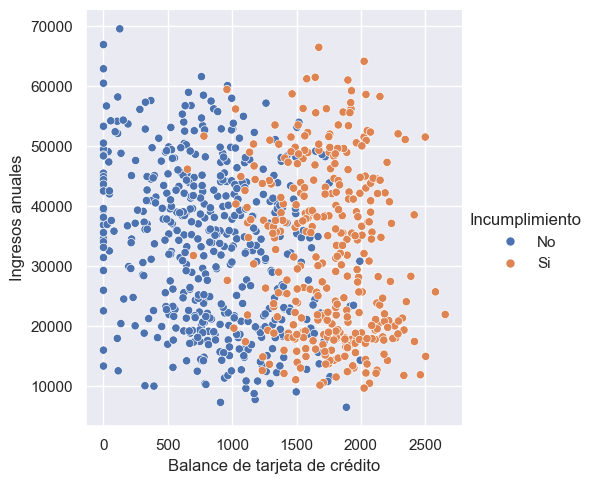

In [9]:
#Hacemos esto para poder graficar y poder visualizar mejor
df_sample_no_default = default_df[default_df["default"] == 0].copy()
df_sample_no_default = df_sample_no_default.sample(frac=0.05)
df_sample_default = default_df[default_df["default"] == 1].copy()

g = sns.relplot(data=pd.concat([df_sample_no_default, df_sample_default]), x="balance", y="income", hue="Incumplimiento", 
                kind="scatter", legend=True)
plt.xlabel("Balance de tarjeta de crédito")
plt.ylabel("Ingresos anuales");

### Modelo de regresión logística

Para tener un punto de comparación, usemos el modelo de regresión logística realizado en Inteligencia Artificial.

In [10]:
from sklearn.linear_model import LogisticRegression

In [11]:
# como siempre vamos separando nuestras variables predictoras de la variable a predecir
X = default_df.loc[:, ["balance", "income", "student"]].values
y = default_df.loc[:, "default"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0, stratify=y)

In [12]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()

X_train = sc_X.fit_transform(X_train) 
X_test = sc_X.transform(X_test)

In [13]:
model_logistic = LogisticRegression(random_state = 0, class_weight="balanced")
model_logistic.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', random_state=0)

In [14]:
y_pred = model_logistic.predict(X_test)

# Creamos la matriz de confusión
cm_logistic = confusion_matrix(y_test, y_pred)

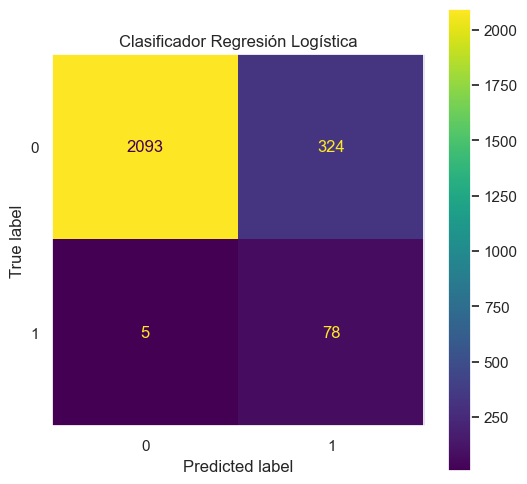

In [15]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_logistic,
                              display_labels=model_logistic.classes_)

fig, ax = plt.subplots(figsize=(6,6))
ax.grid(False)
disp.plot(ax=ax)
ax.set_title("Clasificador Regresión Logística");

In [16]:
# Midamos la sensibilidad y especificidad
print("Clasificador Regresión Logística")
P = np.sum(cm_logistic[1, :])
N = np.sum(cm_logistic[0, :])
TP = cm_logistic[1, 1]
TN = cm_logistic[0, 0]
TPR = TP/P
TNR = TN/N
print(f"Sensibilidad: {TP/P}")
print(f"Especificidad: {TN/N}")
print(f"Exactitud balanceada: {(TPR + TNR)/2}")
print(f"Precision: {precision_score(y_test, y_pred, zero_division=0)}")
print(f"Recuperación: {recall_score(y_test, y_pred, zero_division=0)}")
print(f"F1-score: {f1_score(y_test, y_pred, zero_division=0)}")

Clasificador Regresión Logística
Sensibilidad: 0.9397590361445783
Especificidad: 0.8659495242035581
Exactitud balanceada: 0.9028542801740682
Precision: 0.19402985074626866
Recuperación: 0.9397590361445783
F1-score: 0.3216494845360825


## Clasificador KNN

Vamos a usar el clasificador KNN de [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html). Para este ejemplo, vamos a usar el mismo dataset de la regresión logistica.

In [17]:
# Entrenamos
from sklearn.neighbors import KNeighborsClassifier

classifier_knn = KNeighborsClassifier(n_neighbors=23, metric="minkowski", p=2)
classifier_knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=23)

In [18]:
#Evaluamos
y_pred  = classifier_knn.predict(X_test)

cm_knn = confusion_matrix(y_test, y_pred)

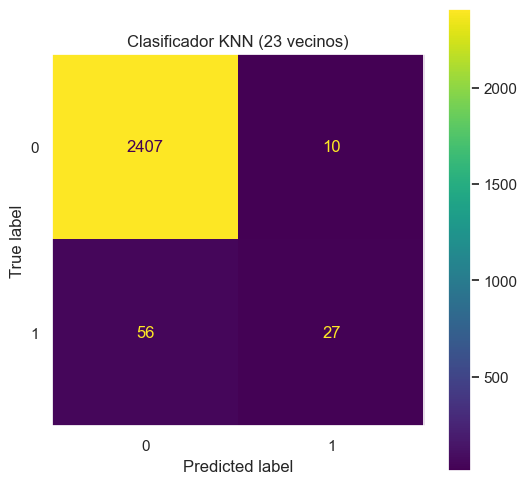

In [19]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_knn,
                              display_labels=classifier_knn.classes_)

fig, ax = plt.subplots(figsize=(6,6))
ax.grid(False)
disp.plot(ax=ax)
ax.set_title("Clasificador KNN (23 vecinos)");

In [20]:
# Midamos la sensibilidad y especificidad
print("Clasificador KNN (23 vecinos)")
P = np.sum(cm_knn[1, :])
N = np.sum(cm_knn[0, :])
TP = cm_knn[1, 1]
TN = cm_knn[0, 0]
TPR = TP/P
TNR = TN/N
print(f"Sensibilidad: {TP/P}")
print(f"Especificidad: {TN/N}")
print(f"Exactitud balanceada: {(TPR + TNR)/2}")
print(f"Precision: {precision_score(y_test, y_pred, zero_division=0)}")
print(f"Recuperación: {recall_score(y_test, y_pred, zero_division=0)}")
print(f"F1-score: {f1_score(y_test, y_pred, zero_division=0)}")

Clasificador KNN (23 vecinos)
Sensibilidad: 0.3253012048192771
Especificidad: 0.9958626396359123
Exactitud balanceada: 0.6605819222275947
Precision: 0.7297297297297297
Recuperación: 0.3253012048192771
F1-score: 0.45


Veamos la frontera de decisión

In [21]:
X = default_df.loc[:, ["balance", "income"]].values
y = default_df.loc[:, "default"].values
X_train_two, X_test_two, y_train_two, y_test_two = train_test_split(X, y, test_size = 0.25, random_state = 0, stratify=y)

sc_X = StandardScaler()
X_train_two = sc_X.fit_transform(X_train_two)

classifier_knn_two = KNeighborsClassifier(n_neighbors=23, metric="minkowski", p=2)
classifier_knn_two.fit(X_train_two, y_train_two)

KNeighborsClassifier(n_neighbors=23)

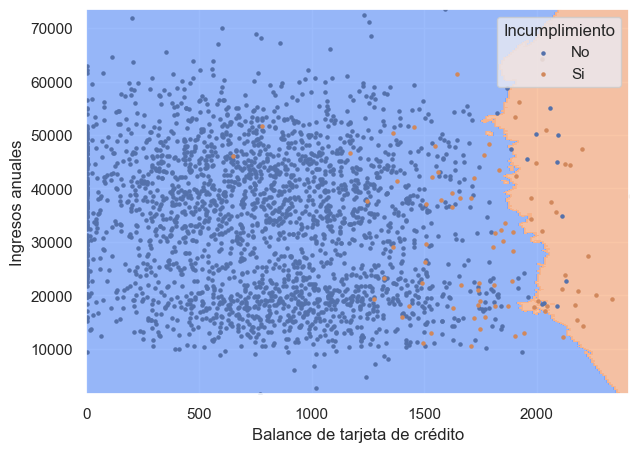

In [22]:
from matplotlib.colors import ListedColormap

# Crear la malla de puntos para el gráfico
X_set, y_set = X_test_two, y_test_two
X1, X2 = np.meshgrid(
    np.arange(start=X_set[:, 0].min() - 1, stop=X_set[:, 0].max() + 1, step=10),
    np.arange(start=X_set[:, 1].min() - 1, stop=X_set[:, 1].max() + 1, step=10)
)

X_cont = sc_X.transform(np.array([X1.ravel(), X2.ravel()]).T)

# Crear el gráfico de contorno
plt.figure(figsize=(7, 5))
plt.contourf(
    X1, X2, classifier_knn_two.predict(X_cont).reshape(X1.shape),
    alpha=0.75, cmap=ListedColormap(['#7aa5fb', '#f8b389'])
)
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())

# Graficar los puntos de entrenamiento
lab = ["No", "Si"]
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(
        X_set[y_set == j, 0], X_set[y_set == j, 1],
        color=ListedColormap(['#5471ab', '#d1885c'])(i), label=lab[i],
        s=5
    )

plt.xlabel('Balance de tarjeta de crédito') 
plt.ylabel('Ingresos anuales') 
plt.legend(title="Incumplimiento")

plt.show()